In [118]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import pyspark as ps

In [119]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('constructionPermitsAustin')
         .getOrCreate()
        )
sc = spark.sparkContext

In [120]:
sc

<SparkContext master=local[4] appName=constructionPermitsAustin>

In [121]:
permits_all = spark.read.csv('../data/Issued_Construction_Permits.csv',
                    header=True,
                    sep=",",
                    inferSchema=True)

# permits_all.printSchema()

# print(f'line count: {permits_all.count()}')

# permits_all.show()

In [122]:
permits_all.createOrReplaceTempView('permits')

In [123]:
permits_2019 = spark.sql('SELECT * from permits WHERE `Calendar Year Issued` = 2019')

In [124]:
permits_2020 = spark.sql('SELECT * from permits WHERE `Calendar Year Issued` = 2020')

In [125]:
permits_2020_df = permits_2020.toPandas()

In [126]:
# permits_2020_df.info()

In [127]:
# permits_2020_df['Location'].value_counts()

In [128]:
permits_2020_df_cleaned = permits_2020_df.drop(columns=['Project Name',
                                                        'TCAD ID',
                                                        'Property Legal Description',
                                                        'Issued In Last 30 Days',
                                                        'Issuance Method',
                                                        'Original Address 1',
                                                        'Original City',
                                                        'Original State',
                                                        'Jurisdiction',
                                                        'Link',
                                                        'Project ID',
                                                        'Master Permit Num',
                                                        'Location',
                                                        'Contractor Phone',
                                                        'Contractor Phone',
                                                        'Contractor Phone',
                                                        'Contractor Address 1',
                                                        'Contractor Address 2',
                                                        'Contractor City',
                                                        'Contractor Zip',
                                                        'Applicant Phone',
                                                        'Applicant Address 1',
                                                        'Applicant Address 2',
                                                        'Applicant City',
                                                        'Applicant Zip',
                                                        'Total Lot SQFT'])

# permits_2020_pd_cleaned

In [129]:
permits_2020_df_cleaned['Applied Date'] = pd.to_datetime(permits_2020_df_cleaned['Applied Date'])
permits_2020_df_cleaned['Issued Date'] = pd.to_datetime(permits_2020_df_cleaned['Issued Date'])
permits_2020_df_cleaned['Status Date'] = pd.to_datetime(permits_2020_df_cleaned['Status Date'])
permits_2020_df_cleaned['Expires Date'] = pd.to_datetime(permits_2020_df_cleaned['Expires Date'])
permits_2020_df_cleaned['Completed Date'] = pd.to_datetime(permits_2020_df_cleaned['Completed Date'])

In [130]:
permits_2020_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69317 entries, 0 to 69316
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Permit Type                   69317 non-null  object        
 1   Permit Type Desc              69317 non-null  object        
 2   Permit Num                    69317 non-null  object        
 3   Permit Class Mapped           69317 non-null  object        
 4   Permit Class                  69317 non-null  object        
 5   Work Class                    69317 non-null  object        
 6   Condominium                   53516 non-null  object        
 7   Description                   69317 non-null  object        
 8   Applied Date                  69314 non-null  datetime64[ns]
 9   Issued Date                   69317 non-null  datetime64[ns]
 10  Day Issued                    69317 non-null  object        
 11  Calendar Year Issued        

In [131]:
permit_year = spark.sql('''SELECT `Calendar Year Issued`, COUNT(*)
                        from permits 
                        WHERE `Calendar Year Issued` > 1990 AND `Calendar Year Issued` < 2021
                        GROUP BY `Calendar Year Issued`
                        ORDER BY 1''')

<AxesSubplot:>

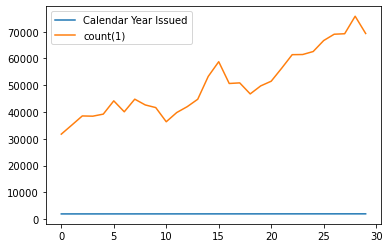

In [132]:
permit_year_df = permit_year.toPandas()
permit_year_df.plot()

In [149]:
permit_date = spark.sql('''SELECT `Applied Date`,`Issued Date`
                        from permits 
                        ORDER BY 2''')

In [150]:
permit_date_df = permit_date.toPandas().dropna()

In [151]:
permit_date_df['Applied Date'] = pd.to_datetime(permit_date_df['Applied Date'])
permit_date_df['Issued Date'] = pd.to_datetime(permit_date_df['Issued Date'])
permit_date_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038829 entries, 0 to 2038852
Data columns (total 2 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Applied Date  datetime64[ns]
 1   Issued Date   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 46.7 MB


In [311]:
import datetime
permit_date_df_after_1990 = permit_date_df[permit_date_df['Applied Date'] >= datetime.datetime(1990,1,1)]
permit_date_df_after_1990

,Applied Date,Issued Date
477291,1990-01-02,1990-01-02
477292,1990-01-02,1990-01-02
477293,1990-01-02,1990-01-02
477294,1990-01-02,1990-01-02
477295,1990-01-02,1990-01-02
...,...,...
2038848,2020-05-15,2021-03-28
2038849,2019-12-10,2021-03-28
2038850,2021-01-19,2021-03-28
2038851,2021-02-03,2021-03-28


In [377]:
permit_by_month = permit_date_df_after_1990.groupby(permit_date_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_by_month.index = permit_by_month.index.astype('datetime64[ns]')
permit_by_month['# of Applications'] = permit_by_month['Applied Date']
permit_by_month = permit_by_month.drop(['Applied Date'], axis=1)
permit_by_month = permit_by_month.drop(['Issued Date'], axis=1)
permit_by_month

,# of Applications
Applied Date,
1990-01-01,2525
1990-02-01,2449
1990-03-01,2844
1990-04-01,2580
1990-05-01,3030
...,...
2020-11-01,4037
2020-12-01,3445
2021-01-01,3205


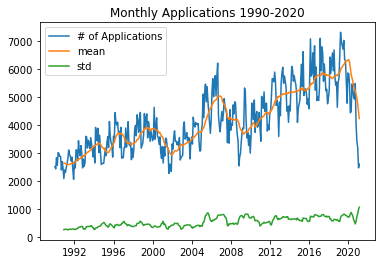

In [406]:
fig, ax = plt.subplots()
ax.plot(permit_by_month, label="# of Applications")
ax.plot(permit_by_month.rolling(window=12).mean(), label="mean")
ax.plot(permit_by_month.rolling(window=12).std(), label="std")
ax.legend()
ax.set_title("Monthly Applications 1990-2020");

In [379]:
pending_time = (permit_date_df_after_1990['Issued Date'] - permit_date_df_after_1990['Applied Date'])

In [380]:
pending_time = pending_time.dt.days.astype('int16')

In [381]:
pending_time_slice = pending_time[(pending_time <= 50) & (pending_time > 0)]

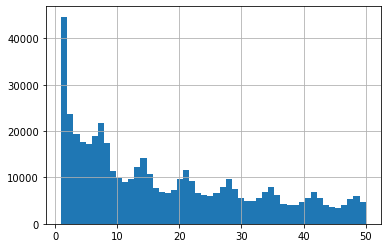

In [382]:
pending_time_slice.hist(bins=50);

In [407]:
permit_by_month_2010_2020 = permit_by_month[
    (permit_by_month.index  >= datetime.datetime(2010,1,1)) &
    (permit_by_month.index  < datetime.datetime(2020,1,1))]
permit_by_month_2010_2020

,# of Applications
Applied Date,
2010-01-01,3010
2010-02-01,3642
2010-03-01,4797
2010-04-01,4604
2010-05-01,4205
...,...
2019-08-01,7034
2019-09-01,6350
2019-10-01,6313


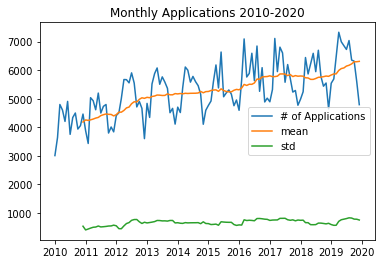

In [409]:
fig, ax = plt.subplots()
ax.plot(permit_by_month_2010_2020, label="# of Applications")
ax.plot(permit_by_month_2010_2020.rolling(window=12).mean(), label="mean")
ax.plot(permit_by_month_2010_2020.rolling(window=12).std(), label="std")
ax.legend()
ax.set_title("Monthly Applications 2010-2020");

Applied Date
2010-01-01   -591.998843
2010-02-01   -503.549769
2010-03-01    583.413194
2010-04-01    568.848380
2010-05-01    546.542824
2010-06-01    701.593750
2010-07-01    126.454861
2010-08-01    417.700231
2010-09-01    -28.290509
2010-10-01   -343.276620
2010-11-01   -618.096065
2010-12-01   -859.341435
Freq: MS, Name: seasonal, dtype: float64

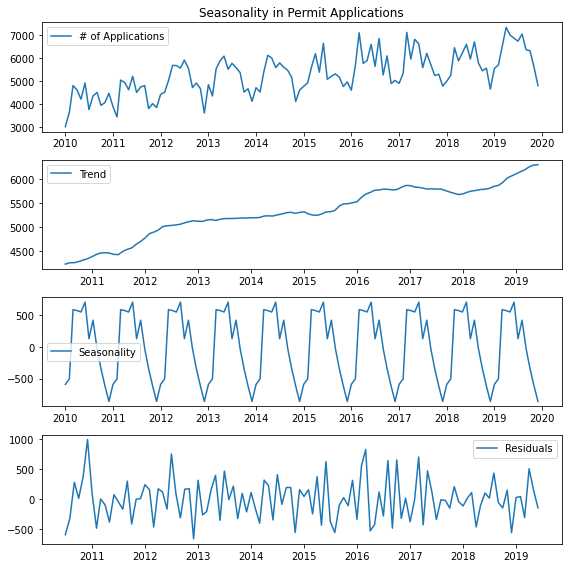

In [413]:
decomposition = seasonal_decompose(permit_by_month_2010_2020, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(4, 1, figsize=(8, 8))

ax[0].plot(permit_by_month_2010_2020, label='# of Applications')
ax[0].legend()
ax[1].plot(trend, label='Trend')
ax[1].legend()
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend()
ax[3].plot(residual, label='Residuals')
ax[3].legend()

ax[0].set_title("Seasonality in Permit Applications")

plt.tight_layout()
seasonal[:12]

In [423]:
permit_type = spark.sql('''SELECT
                        `Permit Type`,
                        COUNT(*) as `Permit Count`
                        from permits
                        GROUP BY `Permit Type`
                        ORDER BY 2 DESC''')
permit_type_df = permit_type.toPandas()
permit_type_df

,Permit Type,Permit Count
0,EP,586012
1,PP,454242
2,BP,450018
3,MP,441636
4,DS,106945


In [422]:
permit_type_desc = spark.sql('''SELECT
                            `Permit Type Desc`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Permit Type Desc`
                            ORDER BY 2 DESC''')
permit_type_desc_df = permit_type_desc.toPandas()
permit_type_desc_df

,Permit Type Desc,Permit Count
0,Electrical Permit,586012
1,Plumbing Permit,454242
2,Building Permit,450018
3,Mechanical Permit,441636
4,Driveway / Sidewalks,106945


In [420]:
permit_class_mapped = spark.sql('''SELECT
                                `Permit Class Mapped`,
                                COUNT(*) as `Permit Count`
                                from permits
                                GROUP BY `Permit Class Mapped`''')
permit_class_mapped_df = permit_class_mapped.toPandas()
permit_class_mapped_df

,Permit Class Mapped,Permit Count
0,Residential,1368219
1,Commercial,670634


In [425]:
permit_class = spark.sql('''SELECT
                            `Permit Class`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Permit Class`
                            ORDER BY 2 DESC''')
permit_class_df = permit_class.toPandas()
permit_class_df

,Permit Class,Permit Count
0,Residential,527907
1,R- 101 Single Family Houses,401403
2,C-1000 Commercial Remodel,255890
3,Commercial,157768
4,R- 435 Renovations/Remodel,143394
...,...,...
62,C- 647 Demolition 3 and 4 Family Bldgs,29
63,C-2003 Commercial Retaining Wall,25
64,C-2002 Commercial Boat Dock,21
65,Replace of Curb & Gutter,8


In [426]:
work_class = spark.sql('''SELECT
                            `Work Class`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Work Class`
                            ORDER BY 2 DESC''')
work_class_df = work_class.toPandas()
work_class_df

,Work Class,Permit Count
0,Remodel,834415
1,New,729882
2,Repair,118527
3,Addition,81523
4,Change Out,73408
5,Addition and Remodel,44687
6,None,42384
7,Irrigation,33247
8,Demolition,16816
9,Wall,12555


In [427]:
description = spark.sql('''SELECT
                            `Description`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Description`
                            ORDER BY 2 DESC''')
description_df = description.toPandas()
description_df

,Description,Permit Count
0,New Residence,62700
1,Replacement of complete existing central heat ...,18971
2,Connect Mobile Home,16600
3,Mobile Home,7918
4,Two Story Residence WAtt Garage,7093
...,...,...
504174,Demolish Detached Garage See 2009005858,1
504175,Change Of Use of partial space of existing Lau...,1
504176,Convert Exist Sf Res To Duplex And Add Second ...,1
504177,New Construction WarehouseDistribution Unit A,1


In [428]:
description_df[:20]

,Description,Permit Count
0,New Residence,62700
1,Replacement of complete existing central heat ...,18971
2,Connect Mobile Home,16600
3,Mobile Home,7918
4,Two Story Residence WAtt Garage,7093
5,Replacement of an existing water heater,6970
6,One Story Residence WAtt Garage,6176
7,New Two Story Res WAtt Garage Covered Patio P...,5925
8,Res,5896
9,Two Stry Frm Res WMas Ven Att Garage,5513


In [429]:
import string
from string import punctuation
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stopwords = ENGLISH_STOP_WORDS

In [433]:
description_df_cleaned = description_df.copy()
description_df_cleaned = description_df_cleaned[description_df_cleaned["Description"].notna()]
description_df_cleaned["Description"] = description_df_cleaned["Description"].str.lower()

description_df_cleaned["Description"] = description_df_cleaned["Description"].str.replace('[^\w\s]',' ')
description_df_cleaned["Description"] = description_df_cleaned["Description"].str.split()
description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: [item for item in x if item not in punctuation])
description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: [item for item in x if item not in stopwords])
#description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: [item for item in x if len(item) > 4])
description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: set(x))

description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: ' '.join(map(str, x)))
description_df_cleaned["Description"]
most_words = Counter(" ".join(description_df_cleaned["Description"]).split()).most_common(100)
most_words

<ipython-input-433-58b6c7a976f3>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  description_df_cleaned["Description"] = description_df_cleaned["Description"].str.replace('[^\w\s]',' ')


[('new', 126598),
 ('existing', 111248),
 ('residence', 68245),
 ('remodel', 62794),
 ('garage', 51087),
 ('res', 49975),
 ('install', 47552),
 ('replace', 46989),
 ('sf', 37674),
 ('2', 37367),
 ('interior', 36652),
 ('porch', 36013),
 ('repair', 30665),
 ('covered', 29937),
 ('story', 29576),
 ('attached', 27902),
 ('add', 27116),
 ('service', 26454),
 ('patio', 26083),
 ('sign', 25744),
 ('water', 23946),
 ('bldg', 22826),
 ('wall', 21773),
 ('driveway', 21282),
 ('permit', 21228),
 ('elec', 21216),
 ('1', 20941),
 ('line', 20397),
 ('change', 20189),
 ('electrical', 19772),
 ('building', 19722),
 ('home', 19313),
 ('family', 18937),
 ('create', 18432),
 ('meter', 18317),
 ('exist', 18307),
 ('demo', 18001),
 ('gas', 17730),
 ('office', 17434),
 ('loop', 17405),
 ('single', 17097),
 ('unit', 16880),
 ('construct', 16368),
 ('city', 16305),
 ('hvac', 15940),
 ('approach', 15874),
 ('construction', 15850),
 ('addition', 15774),
 ('sidewalk', 15359),
 ('3', 14972),
 ('kitchen', 14947),

In [439]:
permit_mechanical = spark.sql('''SELECT `Applied Date`,`Description`
                                FROM permits
                                WHERE `Permit Type` = 'MP'
                                ORDER BY 1''')
permit_mechanical_df = permit_mechanical.toPandas().dropna()
permit_mechanical_df

,Applied Date,Description
5,1921/09/20,New Const Two Sty WdFrm Brick FourPlex
6,1969/05/14,Remodel Int1 Stry Stl And Metal Bldg
7,1970/08/01,One Stry Frm Dup WMas Ven Att Gar
8,1970/10/01,Remodel Exist 1stywd Frm Bldg
9,1971/04/27,Two Stry Frm Res With Mas Ven And Att Gar
...,...,...
441631,2021/03/24,Replacement of complete existing central heat ...
441632,2021/03/24,BP for mobile home with trades Decks 4x4 and 8x8
441633,2021/03/24,Connect mobile home and decks
441634,2021/03/24,Replacement of complete existing central heat ...


In [440]:
permit_mechanical_df['Applied Date'] = pd.to_datetime(permit_mechanical_df['Applied Date'])
permit_mechanical_df_after_1990 = permit_mechanical_df[permit_mechanical_df['Applied Date'] >= datetime.datetime(1990,1,1)]
permit_mechanical_df_after_1990

,Applied Date,Description
127844,1990-01-02,Security Lighting Commercial
127845,1990-01-02,Two Story Residence WAttached Garage
127846,1990-01-02,Two Story Residence WAttached Garage
127847,1990-01-02,One Story Residence WAttached Garage
127848,1990-01-02,New Residence
...,...,...
441631,2021-03-24,Replacement of complete existing central heat ...
441632,2021-03-24,BP for mobile home with trades Decks 4x4 and 8x8
441633,2021-03-24,Connect mobile home and decks
441634,2021-03-24,Replacement of complete existing central heat ...


In [442]:
permit_mechanical_by_month = permit_mechanical_df_after_1990.groupby(permit_mechanical_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_mechanical_by_month.index = permit_mechanical_by_month.index.astype('datetime64[ns]')
permit_mechanical_by_month['Mechanical Count'] = permit_mechanical_by_month['Applied Date']
permit_mechanical_by_month = permit_mechanical_by_month.drop(['Applied Date'], axis=1)
permit_mechanical_by_month = permit_mechanical_by_month.drop(['Description'], axis=1)
permit_mechanical_by_month

,Mechanical Count
Applied Date,
1990-01-01,666
1990-02-01,645
1990-03-01,702
1990-04-01,663
1990-05-01,820
...,...
2020-11-01,553
2020-12-01,423
2021-01-01,343


<AxesSubplot:xlabel='Applied Date'>

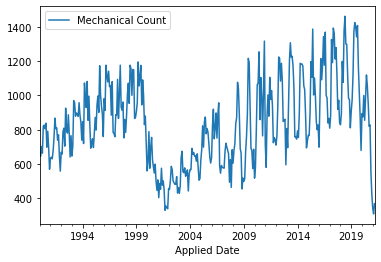

In [443]:
permit_mechanical_by_month.plot()